In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import tensorflow as tf

from tensorflow import convert_to_tensor
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import load_img, smart_resize, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, decode_predictions, preprocess_input

from sklearn.decomposition import FastICA, PCA

### Load VGG19 pre-treined model from the tensorflow library

In [3]:
model = VGG19()

2023-11-26 15:44:19.926641: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-11-26 15:44:19.927887: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-11-26 15:44:19.954795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-26 15:44:19.955474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce 940MX computeCapability: 5.0
coreClock: 1.2415GHz coreCount: 3 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 13.41GiB/s
2023-11-26 15:44:19.955599: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-11-26 15:44:20.071286: I tensorflow/stream_executor/platform/defaul

574717952/574710816 [==============================] - 100s 0us/step


2023-11-26 15:46:17.753089: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 411041792 exceeds 10% of free system memory.
2023-11-26 15:46:19.520012: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 67108864 exceeds 10% of free system memory.
2023-11-26 15:46:19.664569: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 16384000 exceeds 10% of free system memory.


In [4]:
for i, layer in enumerate(model.layers[1:]): print(i, '\t\t', layer.name, '\t\t' if len(layer.name) > 5 else '\t\t\t', layer.get_output_at(0).get_shape().as_list())

0 		 block1_conv1 		 [None, 224, 224, 64]
1 		 block1_conv2 		 [None, 224, 224, 64]
2 		 block1_pool 		 [None, 112, 112, 64]
3 		 block2_conv1 		 [None, 112, 112, 128]
4 		 block2_conv2 		 [None, 112, 112, 128]
5 		 block2_pool 		 [None, 56, 56, 128]
6 		 block3_conv1 		 [None, 56, 56, 256]
7 		 block3_conv2 		 [None, 56, 56, 256]
8 		 block3_conv3 		 [None, 56, 56, 256]
9 		 block3_conv4 		 [None, 56, 56, 256]
10 		 block3_pool 		 [None, 28, 28, 256]
11 		 block4_conv1 		 [None, 28, 28, 512]
12 		 block4_conv2 		 [None, 28, 28, 512]
13 		 block4_conv3 		 [None, 28, 28, 512]
14 		 block4_conv4 		 [None, 28, 28, 512]
15 		 block4_pool 		 [None, 14, 14, 512]
16 		 block5_conv1 		 [None, 14, 14, 512]
17 		 block5_conv2 		 [None, 14, 14, 512]
18 		 block5_conv3 		 [None, 14, 14, 512]
19 		 block5_conv4 		 [None, 14, 14, 512]
20 		 block5_pool 		 [None, 7, 7, 512]
21 		 flatten 		 [None, 25088]
22 		 fc1 			 [None, 4096]
23 		 fc2 			 [None, 4096]
24 		 predictions 		 [None, 1000]


In [16]:
def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x +  alphas_x * delta
    return images

# -----------------------------------------------------------

def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)

# -----------------------------------------------------------

def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

# -----------------------------------------------------------

def integrated_gradients(baseline, image, target_class_idx, m_steps=50, batch_size=32):
    # Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

    # Collect gradients.    
    gradient_batches = []
    
    # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]

        gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
        gradient_batches.append(gradient_batch)

    # Concatenate path gradients together row-wise into single tensor.
    total_gradients = tf.concat(gradient_batches, axis=0)

    # Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients)

    # Scale integrated gradients with respect to input.
    integrated_gradients = (image - baseline) * avg_gradients

    return integrated_gradients

# -----------------------------------------------------------

@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(
        baseline=baseline,
        image=image,
        alphas=alpha_batch
    )

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(
        images=interpolated_path_input_batch,
        target_class_idx=target_class_idx
    )

    return gradient_batch

# -----------------------------------------------------------

#@title
def get_img_attributions(image_path, target_class_idx, m_steps=50, cmap=None, overlay_alpha=0.4):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
    
    baseline = baseline = tf.zeros(shape=np.shape(image))
    
    attributions = integrated_gradients(baseline=baseline, image=image, target_class_idx=target_class_idx, m_steps=m_steps)

    # Sum of the attributions across color channels for visualization.
    # The attribution mask shape is a grayscale image with height and width
    # equal to the original image.
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)
    
    return attribution_mask

In [17]:
## Reduces the inputs dimensionality using component analisys methods
def dimReduction(inputs, num_comp, method='pca', normalize=True):
    # Set the selected algorytm
    alg = PCA(n_components=num_comp)
    if(method == 'ica') : alg = FastICA(n_components=num_comp, whiten='unit-variance')
        
    # Fit the data in the selected algorythm.
    maps = []
    for aux in inputs:
        # Get the principlal components
        aux = alg.fit_transform(aux)
        
        if normalize:
            # Normalization
            f_min, f_max = np.amin(aux), np.amax(aux)
            aux = (aux - f_min) / (f_max - f_min)
        
        # Add to the array
        maps.append(aux)
    
    # Print the dimensions of the initial and resulting data
    print(np.shape(inputs[0]), 'to', np.shape(maps)[1:])
    
    return maps

In [18]:
## Reduces the inputs dimensionality using component analisys methods
def dimReductionMean(inputs, normalize=True):
    maps = []
    for aux in inputs:
        
        if normalize:
            # Normalization
            f_min, f_max = np.amin(aux), np.amax(aux)
            aux = (aux - f_min) / (f_max - f_min)
        
        # Add to the array
        maps.append(aux)
    
    # Print the dimensions of the initial and resulting data
    print(np.shape(inputs[0]), 'to', np.shape(maps)[1:])
    
    return maps

In [19]:
# Testing how numpy reshape function rearange the elements to better understand what is going on

#test = np.arange(200).reshape((5, 5, 8))
#print(test)
#print("\n--------------------------\n")
#test = test.reshape(50, 4)
#print(test)
#print("\n--------------------------\n")
#test_red = dimReduction(inputs = [test], num_comp = 1, method = 'ica', normalize = False)
#print(test_red)

### Creates the model to extract all the layer's activations as outputs

In [20]:
# Creates the model to output the activations in all layers but the input layer
layer_outputs = [layer.output for layer in model.layers[1:]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 

### Read the images names

In [21]:
# Get the images names from the folder
images_path = "/home/user/PROG/images/val2017/"
images_names = []
os.chdir(images_path)
for file_name in glob.glob("*.*"):
    images_names.append(file_name)
    
print("Num images: ", len(images_names))

Num images:  45671


## Extracting the layers

### Extract the given layers' activations and resize it to have 2 dimensions with the depth being split in $n$ lines.
### This format makes it easy to apply the PCA for each depth segment and then get the resulting elements avarage.

In [22]:
# Get the outputs from the given layers
def getOutputs(layers, split_depth, images):
    targets_class_idx = []

    # Array with the images to be plotted
    img_plot = []
    
    # Array with the output from the selected layers
    layers_outputs = []
    
    # Array with the class predicted in each image
    classes = []
    
    # Dimensions of a single filter from each layer
    dimensions = []
    setDimensions = True
    
    # ???????????
    predictions = []

    # For each image
    for image in images:
        # Reads and pre-process the images
        os.chdir(images_path)
        img_aux = load_img(image, target_size=(224, 224))
        img_plot.append(img_aux)
        img_aux = img_to_array(img_aux)
        img_aux = img_aux.reshape((1, img_aux.shape[0], img_aux.shape[1], img_aux.shape[2]))
        #img_aux = preprocess_input(img_aux)
        # Extract all layers outputs from the network for a given image
        net_outputs = activation_model.predict(img_aux)
        # Array to store the outputs of the selected layers for a given image
        outputs = []
        
        # For each desired layer
        for i, layer in enumerate(layers):
            if setDimensions: dimensions.append(np.shape(net_outputs[layer]))
            # Get the depht value from that layer's output
            depth = np.shape(net_outputs[layer])[-1]
            # Get the output for the layerand normalize it
            out_aux = net_outputs[layer]
            out_aux = np.array(out_aux, dtype=object)
            out_aux = (out_aux - np.amin(out_aux)) / ( np.amax(out_aux) - np.amin(out_aux))
            # Compute the dimensions for the generated layeris split correctally
            ##  columns = layers's output depth / number of segments the depth will be split in
            columns = int(depth / split_depth[i])
            ##  rows = total number of elements / number of columns
            rows = int(out_aux.size / columns)
            
            # Add the layer output for that image to the array
            maps = []
            for j in range(split_depth[i]):
                map_aux = out_aux[0, :, :, j*columns:(j+1)*columns]
                map_aux = map_aux.reshape((int(map_aux.size / columns), columns))
                maps.append(np.array(map_aux, dtype=object))
            
            # Append the array with the splitted outputs for a given layer for a given image
            outputs.append(np.array(maps, dtype=object))
        
        setDimensions = False
        
        # Append the array with the splitted outputs for all layers for a given image
        layers_outputs.append(np.array(outputs, dtype=object))
        
        # Gets the labels and predictions for each input
        label = model.predict(img_aux)
        targets_class_idx.append(np.argmax(label))
        label = decode_predictions(label)
        label = label[0][0]
        classes.append(label[1])
        predictions.append(str(int(label[2])))
    
    layers_outputs = np.array(layers_outputs, dtype=object)
    
    return img_plot, layers_outputs, classes, dimensions, predictions, targets_class_idx
    

### layers_outputs dimensions => [ images_number : layers : splt_depth : map_size / map_splitted_depth : map_splitted_depth ]

### Extracts a given number of components from each depth segment
### Get the avarage between all depht components and resize the resulting array to have the dimension of one single filter outpput

In [23]:
# Sets variables
# Layers that will be extracted
layers = [20, 19, 18, 17, 10]
for i, layer in enumerate(model.layers[1:]): 
    if i in layers: print(i, '\t\t', layer.name, '\t\t' if len(layer.name) > 5 else '\t\t\t', layer.get_output_at(0).get_shape().as_list())
    
# How many segments will result from the depth component of each output (in the same sequence as the layers were declared)
split_depth = [2, 2, 4, 4, 4]
# Number of random images that will be selected
num_images = 5

images_names = np.random.choice(images_names, num_images)

# Extract the outputs from the selected layers
img_plot, layers_outputs, classes, dimensions, predictions, targets_class_idx = getOutputs(layers, split_depth, images_names)

10 		 block3_pool 		 [None, 28, 28, 256]
17 		 block5_conv2 		 [None, 14, 14, 512]
18 		 block5_conv3 		 [None, 14, 14, 512]
19 		 block5_conv4 		 [None, 14, 14, 512]
20 		 block5_pool 		 [None, 7, 7, 512]


2023-11-26 15:57:32.752449: W tensorflow/core/common_runtime/bfc_allocator.cc:433] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op Conv2D
Current allocation summary follows.
2023-11-26 15:57:32.754266: I tensorflow/core/common_runtime/bfc_allocator.cc:972] BFCAllocator dump for GPU_0_bfc
2023-11-26 15:57:32.754376: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (256): 	Total Chunks: 57, Chunks in use: 56. 14.2KiB allocated for chunks. 14.0KiB in use in bin. 1.7KiB client-requested in use in bin.
2023-11-26 15:57:32.754392: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (512): 	Total Chunks: 3, Chunks in use: 2. 1.8KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2023-11-26 15:57:32.754404: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (1024): 	Total Chunks: 6, Chunks in use: 5. 7.0KiB allocated for chunks. 5.8KiB in use in bin. 5.0KiB client-requested in

ResourceExhaustedError: OOM when allocating tensor with shape[32,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

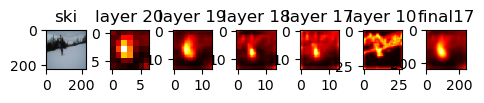

In [24]:
# Number of PCs that will be extracted from each layer element
num_components = [8, 16, 16, 16, 16]

# Array to store the reduced elements
maps = []

# Apply the PCA in each splitted layer batch
# For each layer
for i in range(len(layers)):
    # Array to store a layer's reduced items for all images
    maps_aux = []
    # For each splited element
    aux = layers_outputs[:, i]
    for j in range(split_depth[i]): 
        maps_aux.append([a[j] for a in aux])
        #maps_aux.append(dimReduction([a[j] for a in aux], num_components[i]))
    maps.append(maps_aux)
    

# For each image
for img in range(num_images):
    out = []
    # Get the components map of all layers for that image
    for l, _ in enumerate(layers):
        dim = dimensions[l][1]
        out_aux = np.zeros((dim, dim))
        cont = 0
        for i in range(dim):
            for j in range(dim):
                a = []
                for s in range(split_depth[l]):
                    a.append(maps[l][s][img][cont])
                out_aux[i][j] = np.mean(a)
                cont += 1
        out.append(out_aux)
        

    n = 8
    
    weights  = [0.1, 0.5, 0.3, 0.1, 0]

    plt.subplot(n, n, 1)
    plt.imshow(img_plot[img])
    plt.title(classes[img], loc='center')
    
    curr = 0
    for i in range(len(layers)):
        plt.subplot(n, n, i+2)
        plt.imshow(out[i], cmap='hot')
        plt.title('layer '+str(layers[i]), loc='center')
        curr = i+2
    
    final_arr = []
    for aux in out: final_arr.append(smart_resize( aux.reshape((aux.shape[0], aux.shape[1], 1)), (112, 112)))

 
    final = final_arr[0] * weights[0]
    for el, w in zip(final_arr[1:], weights[1:]):
        final += el*w

    final = (final - np.amin(final) / (np.amax(final) - np.amin(final)))
    final = smart_resize(final, (240, 240))
    
    curr+=1
    plt.subplot(n, n, curr)
    plt.imshow(final, cmap='hot')
    plt.title('final'+str(layers[3]), loc='center')
    
    curr+=1
    atrib = get_img_attributions(image_path=images_path+images_names[img], target_class_idx=targets_class_idx[img], m_steps=50, cmap=plt.hot, overlay_alpha=0.4)
    plt.subplot(n, n, curr)
    atrib = atrib.numpy()
    atrib = smart_resize(atrib.reshape((atrib.shape[0], atrib.shape[1], 1)), (240, 240))
    plt.imshow(atrib, cmap='hot')
    plt.title('integrated_gradients', loc='center')

    plt.subplots_adjust(left=0, bottom=0, right=5, top=8, wspace=0.2, hspace=0.2)
    
    plt.show()

(49, 256) to (49, 8)
(49, 256) to (49, 8)
(196, 256) to (196, 16)
(196, 256) to (196, 16)
(196, 128) to (196, 16)
(196, 128) to (196, 16)
(196, 128) to (196, 16)
(196, 128) to (196, 16)
(196, 128) to (196, 16)
(196, 128) to (196, 16)
(196, 128) to (196, 16)
(196, 128) to (196, 16)
(784, 64) to (784, 16)
(784, 64) to (784, 16)
(784, 64) to (784, 16)
(784, 64) to (784, 16)
(2, 5, 49, 8)


2023-11-26 15:57:54.554801: W tensorflow/core/common_runtime/bfc_allocator.cc:433] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op Conv2D
Current allocation summary follows.
2023-11-26 15:57:54.554916: I tensorflow/core/common_runtime/bfc_allocator.cc:972] BFCAllocator dump for GPU_0_bfc
2023-11-26 15:57:54.554981: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (256): 	Total Chunks: 52, Chunks in use: 47. 13.0KiB allocated for chunks. 11.8KiB in use in bin. 1.1KiB client-requested in use in bin.
2023-11-26 15:57:54.555033: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (512): 	Total Chunks: 4, Chunks in use: 2. 2.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2023-11-26 15:57:54.555090: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (1024): 	Total Chunks: 5, Chunks in use: 5. 5.8KiB allocated for chunks. 5.8KiB in use in bin. 5.0KiB client-requested in

ResourceExhaustedError: OOM when allocating tensor with shape[32,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

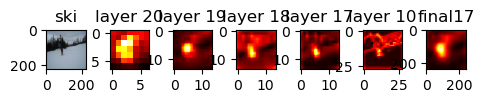

In [25]:
# Number of PCs that will be extracted from each layer element
num_components = [8, 16, 16, 16, 16]

# Array to store the reduced elements
maps = []

# Apply the PCA in each splitted layer batch
# For each layer
for i in range(len(layers)):
    # Array to store a layer's reduced items for all images
    maps_aux = []
    # For each splited element
    aux = layers_outputs[:, i]
    for j in range(split_depth[i]): 
        #maps_aux.append([a[j] for a in aux])
        maps_aux.append(dimReduction([a[j] for a in aux], num_components[i]))
    maps.append(maps_aux)
    
print(np.shape(maps[0]))

# For each image
for img in range(num_images):
    out = []
    # Get the components map of all layers for that image
    for l, _ in enumerate(layers):
        dim = dimensions[l][1]
        out_aux = np.zeros((dim, dim))
        cont = 0
        for i in range(dim):
            for j in range(dim):
                a = []
                for s in range(split_depth[l]):
                    a.append(maps[l][s][img][cont])
                out_aux[i][j] = np.mean(a)
                cont += 1
        out.append(out_aux)
        

    n = 8
    
    weights  = [0.1, 0.5, 0.3, 0.1, 0]

    plt.subplot(n, n, 1)
    plt.imshow(img_plot[img])
    plt.title(classes[img], loc='center')
    
    curr = 0
    for i in range(len(layers)):
        plt.subplot(n, n, i+2)
        plt.imshow(out[i], cmap='hot')
        plt.title('layer '+str(layers[i]), loc='center')
        curr = i+2
    
    final_arr = []
    for aux in out: final_arr.append(smart_resize( aux.reshape((aux.shape[0], aux.shape[1], 1)), (112, 112)))

 
    final = final_arr[0] * weights[0]
    for el, w in zip(final_arr[1:], weights[1:]):
        final += el*w

    final = (final - np.amin(final) / (np.amax(final) - np.amin(final)))
    final = smart_resize(final, (240, 240))
    
    curr+=1
    plt.subplot(n, n, curr)
    plt.imshow(final, cmap='hot')
    plt.title('final'+str(layers[3]), loc='center')
    
    curr+=1
    atrib = get_img_attributions(image_path=images_path+images_names[img], target_class_idx=targets_class_idx[img], m_steps=50, cmap=plt.hot, overlay_alpha=0.4)
    plt.subplot(n, n, curr)
    atrib = atrib.numpy()
    atrib = smart_resize(atrib.reshape((atrib.shape[0], atrib.shape[1], 1)), (240, 240))
    plt.imshow(atrib, cmap='hot')
    plt.title('integrated_gradients', loc='center')

    plt.subplots_adjust(left=0, bottom=0, right=5, top=8, wspace=0.2, hspace=0.2)
    
    plt.show()

## APLICAR TECNICAS DE PROCC DE IMG ANTES DE REDIMENSIONAR -> FILTRO LOGARITIMICO (REALSA AS FEATURES MAIS FORTES E REDUZ AS FEATURES MAIS FRACAS)

## TESTAR FLUXO -> DIVIDE PROFUNDIDADE -> PCA EM CADA ELEMENTO DE PROFUNDIDADE -> MEDIA EM CADA ELEMENTO DE PROFUNDIDADE, REDUZINDO A PROFUNDIDADE DE CADA ELEMENTO PARA 1 -> APLICAR PCA ENTRE OS ELEMENTOS DE PROFUNDIDADE COM APENAS UM PC

## APLICAR POOLING NOS FEATURE MAPS ANTES DE DIVIDIR